Train samples: 697932, Test: 116323
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


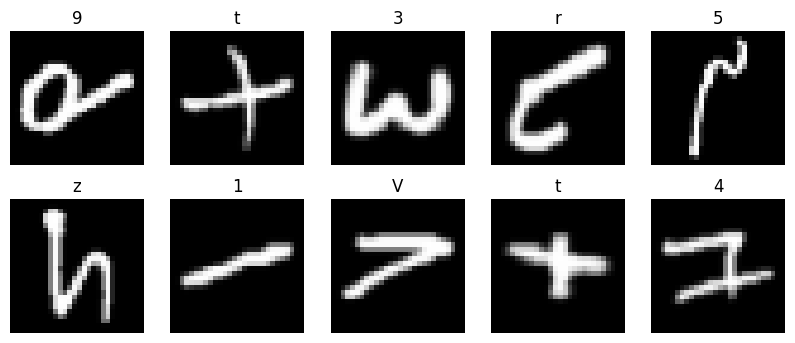

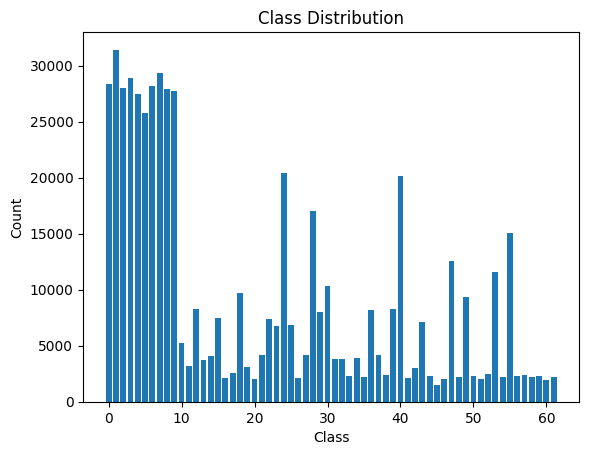

In [11]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split

# Transform: Normalize to [0,1], grayscale already
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor, normalizes 0-1
    transforms.Normalize((0.5,), (0.5,))  # Mean/std for grayscale
])

# Load EMNIST ByClass (62 classes: 0-9, A-Z, a-z)
train_data = datasets.EMNIST(root='./data', split='byclass', train=True, download=True, transform=transform)
test_data = datasets.EMNIST(root='./data', split='byclass', train=False, download=True, transform=transform)

print(f"Train samples: {len(train_data)}, Test: {len(test_data)}")
print(f"Classes: {train_data.classes}")  # 62 classes

# Split train into train/val (70/15/15 overall: ~70% train, ~15% val from train set)
train_size = int(0.82 * len(train_data))  # ~70% overall
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

# Loaders (batch 64, adjust as needed)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# EDA: Visualize samples
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    img, label = train_data[i]
    axs[i//5, i%5].imshow(img.squeeze(), cmap='gray')
    axs[i//5, i%5].set_title(train_data.dataset.classes[label])
    axs[i//5, i%5].axis('off')
plt.show()

# Class distribution (imbalanced, so watch for it)
labels = [label for _, label in train_data]
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [12]:
from torchvision.transforms import RandomRotation, RandomAffine

aug_transform = transforms.Compose([
    transforms.RandomRotation(10),  # Small rotations
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Shifts
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Apply to train only
train_data.dataset.transform = aug_transform

In [13]:
import torch.nn as nn
import torch.optim as optim
from torch.nn import CrossEntropyLoss

# Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=62):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After two pools: 28/4=7
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Init model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train loop (add EarlyStopping manually)
epochs = 2
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Val
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
    
    print(f"Epoch {epoch+1}: Train Loss {train_loss/len(train_loader):.4f}, Val Loss {val_loss/len(val_loader):.4f}, Val Acc {correct/len(val_data):.4f}")

# Save model
torch.save(model.state_dict(), 'emnist_model.pt')

Epoch 1: Train Loss 0.7928, Val Loss 0.5140, Val Acc 0.8199
Epoch 2: Train Loss 0.5874, Val Loss 0.4675, Val Acc 0.8372


c:\Users\4539\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Test Acc: 0.8505, Prec: 0.8310, Rec: 0.8505, F1: 0.8304


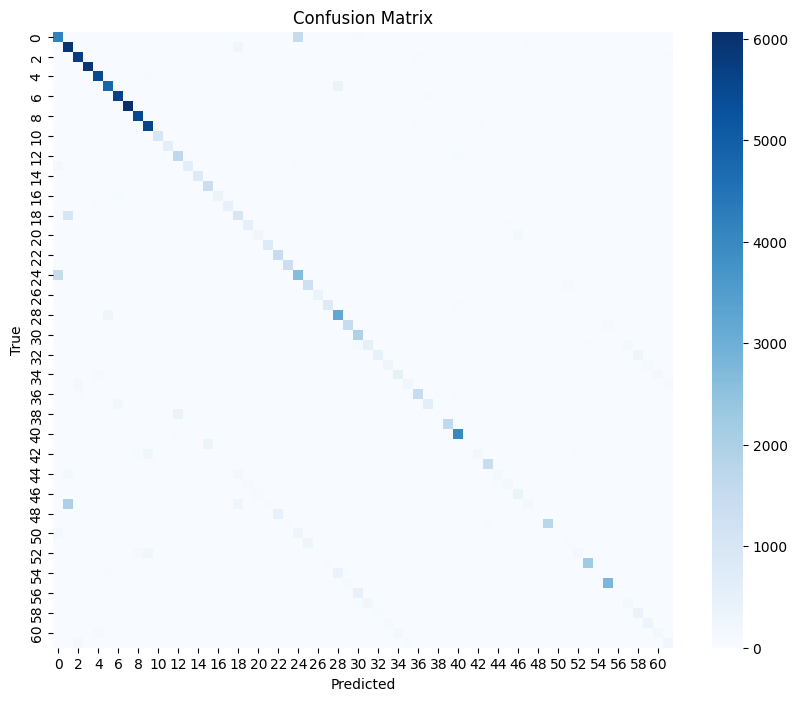

In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Test eval
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Test Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")

# Confusion matrix (focus on errors like O/0)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from flask import Flask, request, jsonify
import torch
from torchvision import transforms
from PIL import Image
import io

app = Flask(__name__)
model = SimpleCNN()
model.load_state_dict(torch.load('emnist_model.pt'))
model.eval()

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

@app.route('/predict', methods=['POST'])
def predict():
    file = request.files['image']
    img = Image.open(io.BytesIO(file.read()))
    img = transform(img).unsqueeze(0)  # Batch dim
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    classes = [...]  # Paste full EMNIST classes list here
    return jsonify({'class': classes[pred]})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

In [17]:
import streamlit as st
from PIL import Image
import requests

st.title('Draw a Char')
drawing = st.canvas(width=200, height=200, stroke_width=10)

if drawing.image_data is not None:
    img = Image.fromarray(drawing.image_data.astype('uint8'))
    img = img.convert('L')  # Grayscale
    img.save('drawn.png')
    files = {'image': open('drawn.png', 'rb')}
    response = requests.post('http://127.0.0.1:5000/predict', files=files)
    st.write(response.json()['class'])

2025-12-12 17:14:44.526 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-12 17:14:44.579 
  command:

    streamlit run c:\Users\4539\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-12-12 17:14:44.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-12 17:14:44.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


AttributeError: module 'streamlit' has no attribute 'canvas'